<a href="https://colab.research.google.com/github/Praneeth-18/DataMining5/blob/main/Audio%20dataset/Audio_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt


In [3]:
y, sr = librosa.load('/content/drive/My Drive/CMPE-256 files/Kepler_ Star KIC12268220C Light Curve Waves to Sound.mp3')


# **EDA**

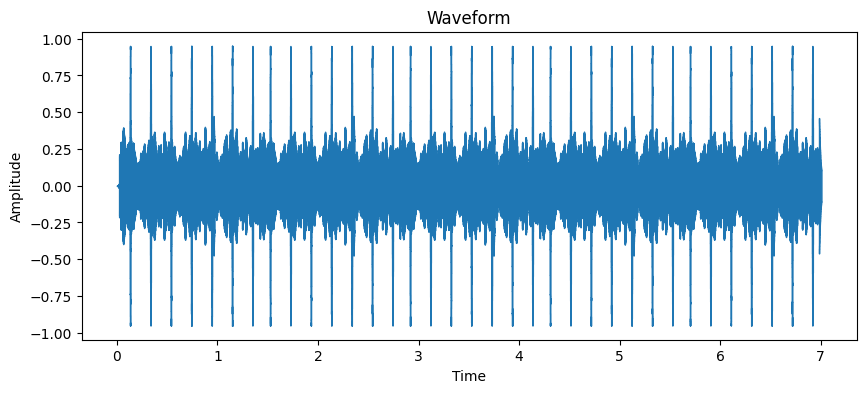

In [4]:
plt.figure(figsize=(10,4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


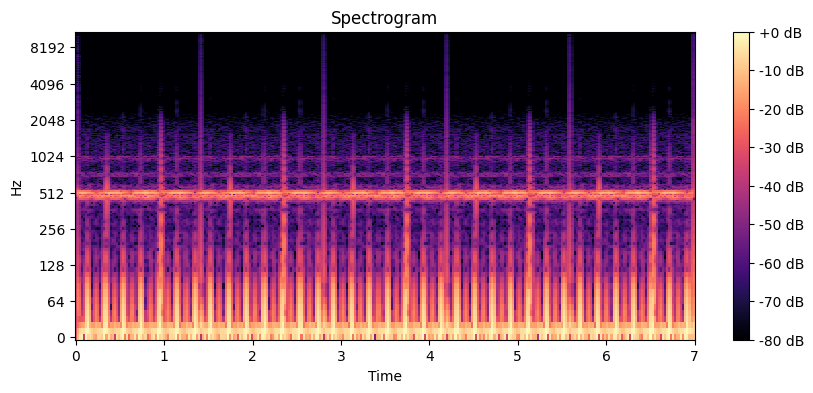

In [5]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10,4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()


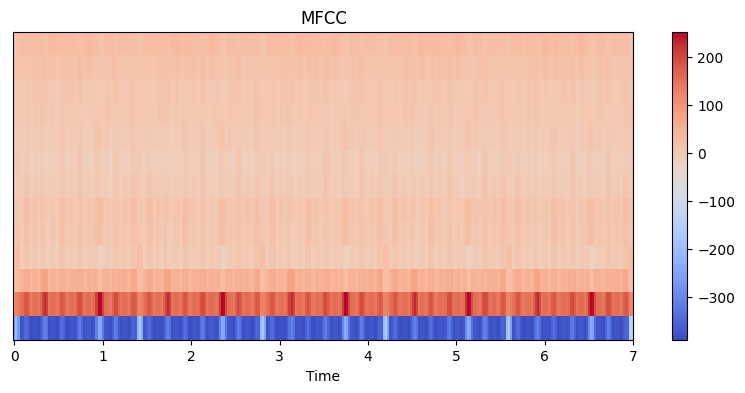

In [6]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()


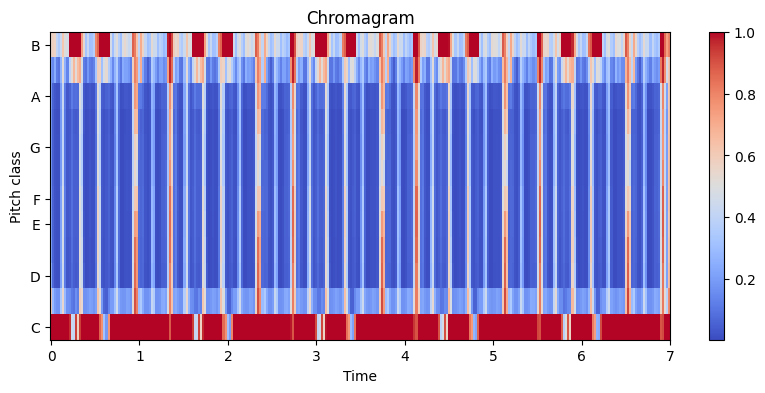

In [7]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chromagram')
plt.show()


In [9]:
import IPython.display as ipd
ipd.Audio('/content/drive/My Drive/CMPE-256 files/Kepler_ Star KIC12268220C Light Curve Waves to Sound.mp3')


In [10]:
# Step 4: Statistical Analysis
# Compute basic statistics on the audio data
mean = np.mean(y)
median = np.median(y)
variance = np.var(y)

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Variance: {variance}")

Mean: 0.00031467279768548906
Median: 0.048956479877233505
Variance: 0.052997440099716187


In [12]:
# Step 5: Data Augmentation
# Time stretching
y_stretch = librosa.effects.time_stretch(y, rate=0.9)

# Pitch shifting
y_shift = librosa.effects.pitch_shift(y, sr=sr, n_steps=4)

# Adding noise
noise = np.random.randn(len(y))
y_noisy = y + 0.005*noise

In [13]:
# Step 6: Check for missing or corrupted audio files
# In this case, we only have one file, so we'll just check if it's corrupted
def is_corrupted(y, sr):
    if len(y) == 0 or sr <= 0:
        return True
    return False

print(f"Is the audio file corrupted? {'Yes' if is_corrupted(y, sr) else 'No'}")

Is the audio file corrupted? No


In [15]:
!pip install librosa noisereduce

In [16]:
import noisereduce as nr
#  Noise Reduction
y_denoised = nr.reduce_noise(y=y, sr=sr)

In [18]:
# Resampling (e.g., to 16kHz)
y_resampled = librosa.resample(y_denoised, orig_sr=sr, target_sr=16000)
sr = 16000

In [19]:
# Normalization
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

y_normalized = normalize_audio(y_resampled)

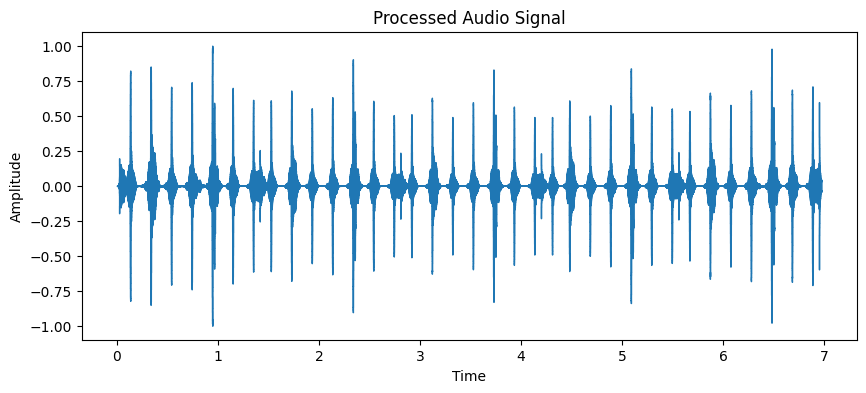

In [20]:
# Silence Removal
intervals = librosa.effects.split(y_normalized, top_db=30)
y_no_silence = np.concatenate([y_normalized[start:end] for start, end in intervals])

# Visualizing the audio signal after preprocessing
plt.figure(figsize=(10,4))
librosa.display.waveshow(y_no_silence, sr=sr)
plt.title('Processed Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


In [22]:
# Feature extraction: MFCC
mfccs = librosa.feature.mfcc(y=y_resampled, sr=sr, n_mfcc=13).T

# **Clustering**

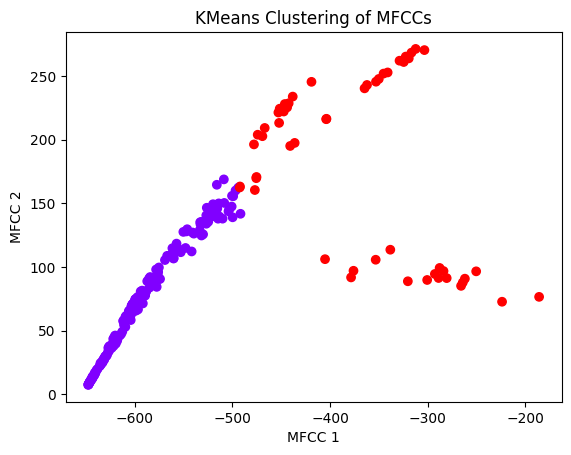

In [25]:
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
# Clustering using KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(mfccs)
labels = kmeans.labels_

# Visualizing clusters
plt.scatter(mfccs[:,0], mfccs[:,1], c=labels, cmap='rainbow')
plt.title('KMeans Clustering of MFCCs')
plt.xlabel('MFCC 1')
plt.ylabel('MFCC 2')
plt.show()


# **Anomaly Detection**

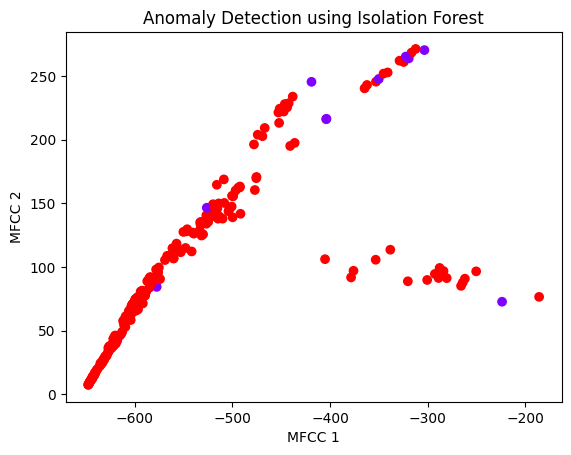

In [26]:
# Anomaly Detection using Isolation Forest
clf = IsolationForest(contamination=0.05, random_state=0)
anomalies = clf.fit_predict(mfccs)

# Visualizing anomalies
plt.scatter(mfccs[:,0], mfccs[:,1], c=anomalies, cmap='rainbow')
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('MFCC 1')
plt.ylabel('MFCC 2')
plt.show()

In [28]:
!pip install tpot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=5bece99b6cc16e29b16ffb8bd2dfb6db2481c60adaef6612cc1df4459a92819e
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


## **Modeling**

In [29]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [33]:
# Extract features (MFCCs) from overlapping segments to create a larger dummy dataset
def extract_features(y, sr):
    return np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)

segment_length = sr * 2  # 2 seconds
overlap = sr * 1  # 50% overlap
segments = (len(y) - segment_length) // overlap + 1

X = np.array([extract_features(y[int(i*overlap):int(i*overlap+segment_length)], sr) for i in range(int(segments))])
y_labels = np.array(["class_{}".format(i%2) for i in range(int(segments))])  # Just simulating two classes

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)


In [38]:
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9735177865612649

Generation 2 - Current best internal CV score: 0.9735177865612649

Generation 3 - Current best internal CV score: 0.9735177865612649

Generation 4 - Current best internal CV score: 0.9735177865612649

Generation 5 - Current best internal CV score: 0.9735177865612649

Best pipeline: LogisticRegression(MultinomialNB(input_matrix, alpha=10.0, fit_prior=False), C=25.0, dual=False, penalty=l2)


TPOTClassifier(generations=5, population_size=20, random_state=42, verbosity=2)

In [39]:
print("TPOT score on testing data:", tpot.score(X_test, y_test))


TPOT score on testing data: 1.0


In [40]:
tpot.export('tpot_best_model.py')
